---
title: Unmixing Onboarding Project
author: Andrei Akopian
date: 2025-09-27
format:
  html:
    code-fold: true
    code-summary: "Show the code"
  pdf:
    code-overflow: wrap
    echo: false
    output: true
---

## Abstract
Onboarding project for the Unmixing part of the Science Team, based on fake and actual data given by Zoe Augspach. Below are my amatur attempts to hit the data with generic statistics methods. Also my general observations about the data. All code is in python. The libraries used are polars, seaborn, SciKit Learn and some python builtins.

## Introduction

The task is to estimate npv_fractions (proportion of dead plants on crop field), from spectra data (pixel broken down by light wavelengths) similar to those the FINCH satellite will be capturing.

I was provided 2 files, one with fake data, and one with real data. The fake data had no noise and was designed to show perfect results on linear regression. All visualization here are for the real data, as it is much more interesting.

In [39]:
#| code-summary: "Imports"
import polars as pl
import seaborn as sns
import sklearn
import re

In [40]:
#| code-summary: "File Paths"
fake_simpler_data_filepath = "unmixing/fake_simpler_data.csv"
simpler_data_filepath = "unmixing/simpler_data.csv"

In [41]:
#| code-summary: "Read Data to Dataframes"
real_data = pl.read_csv(simpler_data_filepath).drop("use")
fake_data = pl.read_csv(fake_simpler_data_filepath).drop("use")

In [42]:
#| code-summar: "Select Dataset to use"
data_in_use = real_data # for easy switching between fake and real
data_in_use = data_in_use.with_row_index()

### Looking at the Data

The training data covers npv_fractions fairly uniformly, except for one dataset that has a lot of 0 npv samples. The fact that data comes from different sources will probably cause trouble at some point.

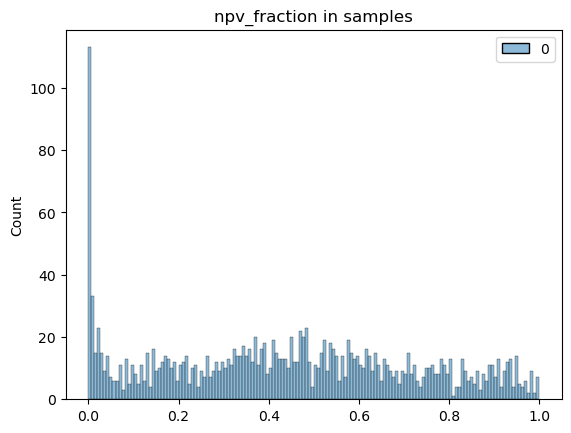

In [43]:
#| code-summary: distribution of npv_fractions in samples
hist = sns.histplot(data_in_use.select(pl.col("npv_fraction")),bins=150,stat="count")
hist.set_title("npv_fraction in samples")
print()

In [44]:
#| code-summary: "Helper functions"
def find_runs(values):
    """
    Convert lists of values into (start,length) tuples.
    """
    if not values:
        return []

    runs = []
    start = values[0]
    length = 1

    for i in range(1, len(values)):
        if values[i] == values[i - 1] + 1:
            length += 1
        else:
            runs.append((start, length))
            start = values[i]
            length = 1

    runs.append((start, length))
    return runs

In [45]:
#| code-summary: "Split Datasets by Source"
#| output: false
# split by source dataset
names = pl.Series(data_in_use.select(pl.col("Spectra")))
def name_swapping(name):
    return re.sub(r"[\d|\s|\_](.+)$","",name)
names = list(map(name_swapping,names.to_list()))

row_i = 0
d = {}
for n in names:
    if n in d:
        d[n].append(row_i)
    else:
        d[n]=[row_i]
    row_i+=1

for k in d:
    d[k] = find_runs(d[k])

frames = []
for n in d:
    frame = pl.DataFrame()
    for run in d[n]:
        frame = pl.concat([frame,data_in_use.slice(run[0],run[1])])
    frames.append(frame.sort(pl.col("npv_fraction")))

print("Number of Datasets:",len(d))

Number of Datasets: 20


In [46]:
#| code-summary: "visualize spectra"
def vis(dataframe,hue="sample_n",title="Spectra plot",legend=False):
    "Takes polars dataframe (use df.sample(10)) and visualises it using seaborn."
    npv_fractions = dataframe.select(pl.col("npv_fraction")).to_numpy()
    numeric = dataframe.select(pl.col(r'^\d+$'))
    transposed = numeric.transpose(
        include_header=True, 
        header_name="wave_lengths",
        # column_names=[f"sample {i}" for i in range(dataframe.shape[0])]
        column_names=[f"s{i}, npv {npv_fractions[i]}" for i in range(dataframe.shape[0])]
    )
    integerized = transposed.with_columns(pl.col("wave_lengths").str.to_integer())
    del transposed
    unpivoted = integerized.unpivot(
        index="wave_lengths",
        value_name = "amplitudes",
        variable_name="sample_n"
    )
    del integerized
    sns.lineplot(x="wave_lengths", data=unpivoted, y="amplitudes",hue=hue,legend=legend).set_title(title)

The spectra within individual datasets don't vary too much, while the npv_fractions vary a lot. This means npv_fractions are relatively sensitive to minor details of the spectra - a likely bottleneck for normal statistical methods.

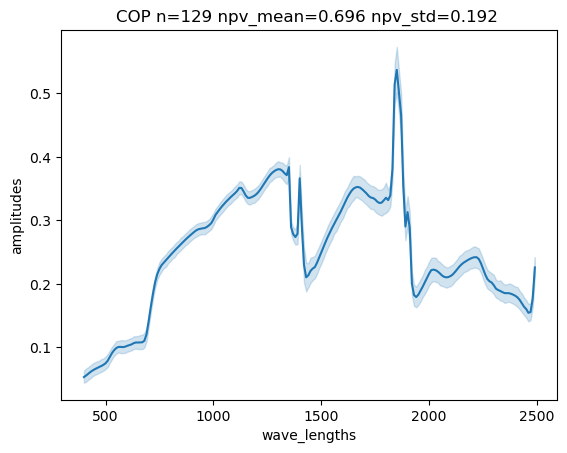

In [47]:
#| code-summary: "Looking at the min-max spectra by data source"
keys = list(d.keys())
i = 4 # 1-20 to select dataset
mean = round(frames[i].mean().item(row=0,column="npv_fraction"),3)
std = round(frames[i].std().item(row=0,column="npv_fraction"),3)
vis(frames[i],None,title=f"{keys[i]} n={len(frames[i])} npv_mean={mean} npv_std={std} ")

Min-max graphs give the impression that higher amplitudes throughout correlate with higher npv.

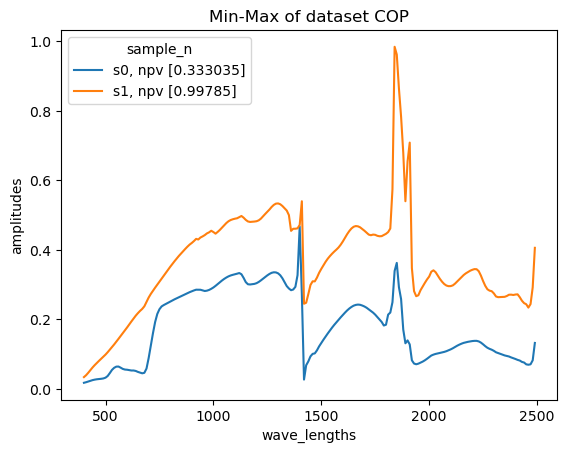

In [48]:
#| code-summary: "Min Max of Spectra (source specific)"
# data_only = frames[i].select(pl.col(r'^\d+$'))
i = 4 # 1-20 to select dataset
min_s =  frames[i].slice(0,1)
max_s =  frames[i].slice(frames[i].shape[0]-1,1)
min_max = pl.concat([min_s,max_s])
vis(min_max,legend=True,title=f"Min-Max of dataset {keys[i]}")

Looking at Q1 and Q3 of the data (which is more resistant to outliers), there are still big differences in npv, but the amplitude-npv relationship is less obvious. The Q3 has lower amplitudes than Q1 for many wavelengths. This is the case in most datasets.

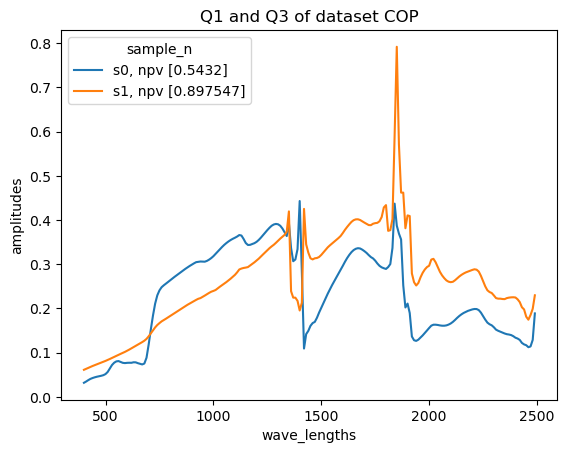

In [49]:
#| code-summary: "Q1 and Q3 of Spectra (source specific)"
# data_only = frames[i].select(pl.col(r'^\d+$'))
i = 4 # 1-20 to select dataset
samples = frames[i].shape[0]
min_s =  frames[i].slice(int(samples*0.25),1)
max_s =  frames[i].slice(int(samples*0.75),1)
min_max = pl.concat([min_s,max_s])
vis(min_max,legend=True,title=f"Q1 and Q3 of dataset {keys[i]}")

## Models
As per onboarding instructions, I started by creating LinearRegression and RandomForest models provided by from SciKit Learn.

### Linear Regression

In [50]:
#| code-summary: "create trainign and validation datasets"
start = 900
end = 1700
selected_cols = [
    col for col in data_in_use.columns
    if col.isdigit() and start <= int(col) <= end
]
numeric_rows = data_in_use.select(selected_cols)
npv_fractions = data_in_use.select(pl.col("npv_fraction"))
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(numeric_rows, npv_fractions, test_size=0.2, random_state=42)

In [51]:
#| code-fold: show
#| code-summary: "Linear Regression"
#| output: false
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X=train_X,y=train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Linear regression has a decent fit if validation is to be believed.
For the onboarding fake data was also provided, which had $r^2=1$. The real world is less firendly:

In [52]:
print("Training R^2:",reg.score(train_X,train_y))
print("Validation R^2:",reg.score(validate_X,validate_y))

Training R^2: 0.7731807959585704
Validation R^2: 0.766064069439525


The coefficients of the linear model are all over the place, even for nearby wavelengths. This means something is wrong with the model. But for now, it seems to work.

In [53]:
len(list(range(start,end+1,10)))

81

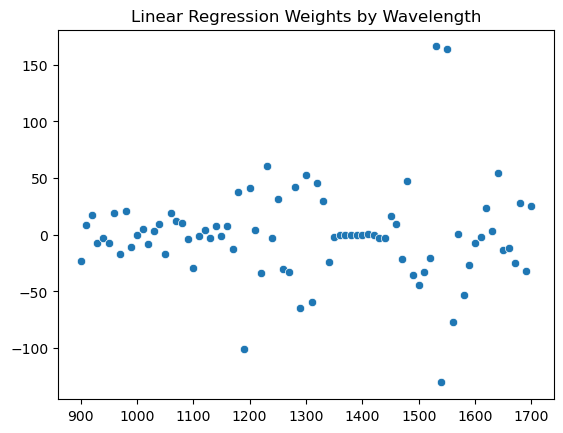

In [55]:
#| code-fold: show
#| code-summary: "Linear Regression Coefficients"
coefficients = reg.coef_
sns.scatterplot(x=list(range(start,end+10,10)),y=coefficients[0],legend=False).set_title("Linear Regression Weights by Wavelength")
print()

The model predicts npv_fractions outside the [0,1] range, and the noise clearly has a patter similar to the logit function. Linear Regression is clearly not the best model for the task. Instead of band-aid solutions like clipping predictions, I will probably pick a model that is designed to output fractions (if I can find one).

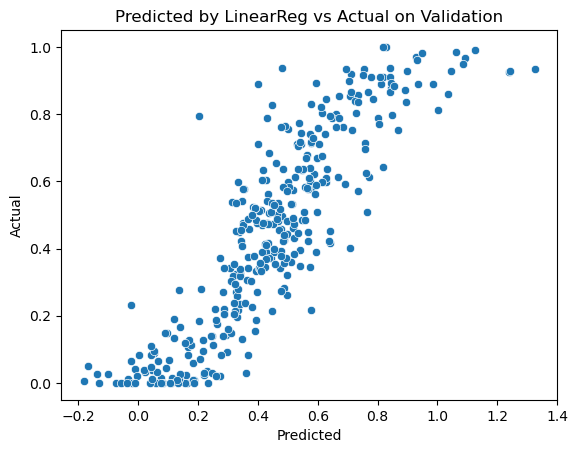

In [58]:
#| code-summary: "Linear Regression Validation"
plot = sns.scatterplot(x=reg.predict(validate_X)[:,0].tolist(),y=validate_y["npv_fraction"].to_list())
plot.set_xlabel("Predicted")
plot.set_ylabel("Actual")
plot.set_title("Predicted by LinearReg vs Actual on Validation")
print()

### Random Forest
I also tried random forest. Random forest tends to overfit, so I am very uncomfortable with picking parameters and calling it a day.

In [59]:
#| code-summary: "fitting Random Forest"
#| output: false
from sklearn import ensemble
forest = ensemble.RandomForestRegressor(
     n_estimators=200,
     max_depth=13,
     max_features = 0.2,
     random_state = 42,
     min_samples_split=5,
)
forest.fit(X=train_X,y=train_y)

/Users/andrei/opt/miniconda3/envs/WorkingPython/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,200
,criterion,'squared_error'
,max_depth,13
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Here is the best performance I managed to get out of RandomForest. Even after adjusting, it is still overfitting.

In [60]:
print("Training R^2:",forest.score(train_X,train_y))
print("Validation R^2:",forest.score(validate_X,validate_y))

Training R^2: 0.891172604830251
Validation R^2: 0.6182059307604615


Unlike Linear regression, Random Forest does not predict values outside [0,1] range, but it has a lot outlier predictions.

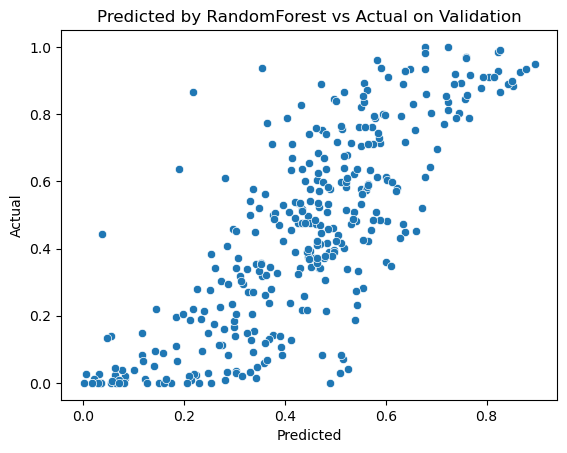

In [61]:
#| code-summary: "Random Forest Validation"
plot = sns.scatterplot(x=forest.predict(validate_X).tolist(),y=validate_y["npv_fraction"].to_list())
plot.set_xlabel("Predicted")
plot.set_ylabel("Actual")
plot.set_title("Predicted by RandomForest vs Actual on Validation")
print()

# Conclusion

I have created a baseline linear regression model I will compare future models to. 

Though $r^2>0.7$ doesn't look too bad, I have already found a lot of issues:

-  the models are clearly overfitting
-  the models are overfitting to training data, so extrapolation on real data the models are intended for will be disasterous.
-  the datasets are inconsistent
-  the models are clearly suboptimal for the task at hand, as they are producing problems that should be impossible, like npv_fraction outside of [0,1].

I will try to improve upon these points in the future.